<h1 style="font-size:30px;">Image Classification using Convolutional Neural Networks</h1>

Image Classification (also called Image Recognition) is the process of labeling or categorizing an image from a set of predefined target classes. Traditionally, in machine learning, image classification solutions involved computing various types of features that were engineered for a particular problem domain. These features were then used as input to train a classifier, such as a Support Vector Machine (SVM) or multinomial Logistics Regression.

With the advent of Deep Convolutional Neural Networks (CNNs), the process has shifted to a more end-to-end learning process (instead of learning only the classifier). In contrast to traditional machine learning techniques, the features are also learned during the training of the CNNs. Deep CNNs can learn to classify images into thousands of classes. These networks also form the basis for many advanced computer vision problems like Segmentation and Object Detection, as we'll see later in this course. In this notebook, you will learn to perform image classification on a few sample images using a pre-trained deep CNN.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_image_classification.png' width=950 align='center'>

## Table of Contents

* [1 Download the Images](#1-Download-the-Images)
* [2 Read and Display Images](#2-Read-and-Display-Images)
* [3  Load the Model (ResNet50)](#3-Load-the-Model-%28ResNet50%29)
* [4 Perform Inference](#4-Perform-Inference)
* [5 Conclusion](#5-Conclusion)

In [ ]:
import torch
import requests
import zipfile
import matplotlib.pyplot as plt
import glob as glob
import os
import ast
import numpy as np
from PIL import Image

## 1 Download the Images

We will use three different images for classification in this notebook. Let's download them first.

In [ ]:
def download_file(url, save_name):

    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    "https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt",
    "imagenet_classes.txt")

download_file(
    'https://www.dropbox.com/s/cprmbjb8l3olyiv/dataset_image_classification_cnn.zip?dl=1',
    'dataset_image_classification_cnn.zip'
)

unzip(zip_file='dataset_image_classification_cnn.zip')

Extracted all


## 2 Read and Display Images

In [ ]:
# Store all the image paths in a list.
image_paths = glob.glob('dataset_image_classification_cnn/*.jpg')
print(image_paths)

['dataset_image_classification_cnn/car.jpg', 'dataset_image_classification_cnn/tiger.jpg', 'dataset_image_classification_cnn/dog.jpg']


### 2.1 Display the Sample Test Images

Before moving on to actual classification, let's display the three test images that we will perform infernce on.

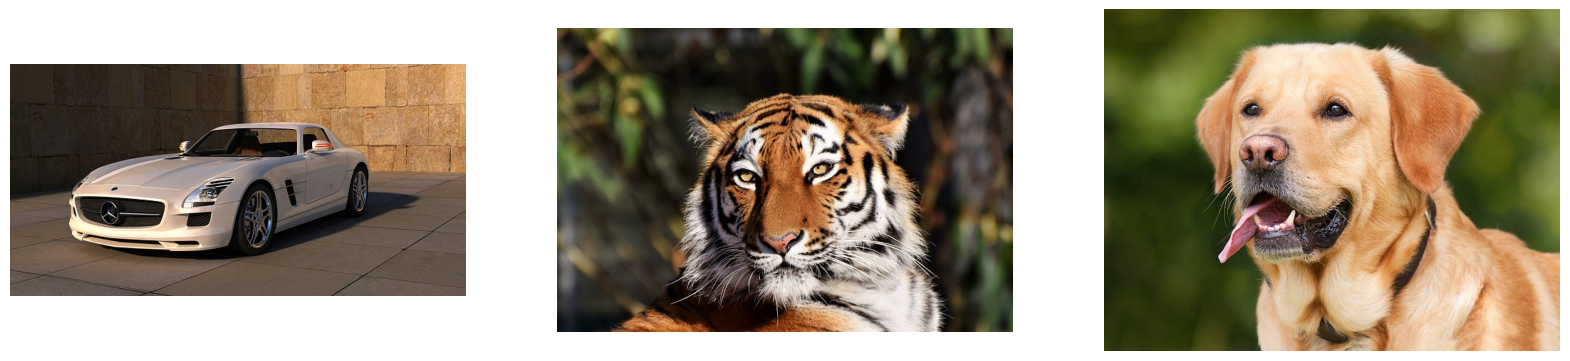

In [ ]:
plt.figure(figsize=(20, 8))
for idx, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    plt.subplot(1, 3, idx+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

## 3 Load the Model (ResNet50)

For this example, we will use the **ResNet50** model available in `torchvision.models`. This model has been pre-trained on the <a href="https://www.image-net.org/index.php" target="_blank">ImageNet</a> 1K dataset, which contains more than 1.2 million training images distributed across 1,000 classes. Such pre-trained models can be used out-of-the-box for many types of classification problems as long as the images we intend to classify are represented in the ImageNet dataset. For reference, here is the list of class labels for ImageNet <a href="https://image-net.org/challenges/LSVRC/2012/browse-synsets" target="_blank">ImageNet Class Labels.</a>

If your problem domain is very specific and contains images that do not have representations in ImageNet (for example, circuit boards, dental x-rays, hand sign language, biological images, etc...), then using a pre-trained model based on ImageNet out-of-the-box will not produce good results. However, as we will learn in a future video, you can use **transfer learning** to leverage pre-trained models for use in specific problem domains, which can be highly effective and is a very common approach that can still leverage the use of large, pre-trained models.

The torchvision API provides the following utility to instantiate a ResNet50 model. For more information on the ResNet50 API in torchvision refer to the documentation page: <a href="https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50" target="_blank">ResNet50</a>
In this notebook, we will initialize the weights from the ImageNet dataset by setting `weights='IMAGENET1K_V1'` as shown in the code cell below.

In [ ]:
# Load the pre-trained ResNet50 model.
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights='IMAGENET1K_V1')
# Set model to eval mode
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 4 Perform Inference

Since we are using the torchvision API, it is straightforward to make predictions using a pre-trained model. In the code below, we will perform the following steps.
1. Read the image
2. Perform the required pre-processing as required by the model.
3. Create a data batch from the images. This is needed because the predict method works on image batches.
4. Pass the image through the model
5. Decode the predictions to find the class name and confidence score of predictions.

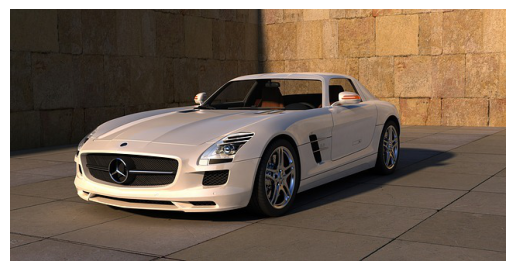

Prediction 0: sports car, 60.14%
Prediction 1: convertible, 33.91%
Prediction 2: car wheel, 3.14%
Prediction 3: grille, 1.34%
Prediction 4: racer, 1.05%


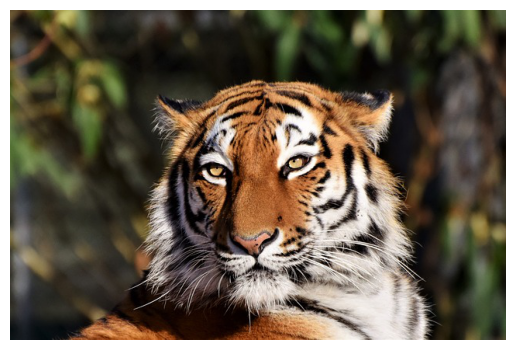

Prediction 0: tiger, 80.59%
Prediction 1: tiger cat, 19.25%
Prediction 2: jaguar, 0.07%
Prediction 3: leopard, 0.03%
Prediction 4: lynx, 0.01%


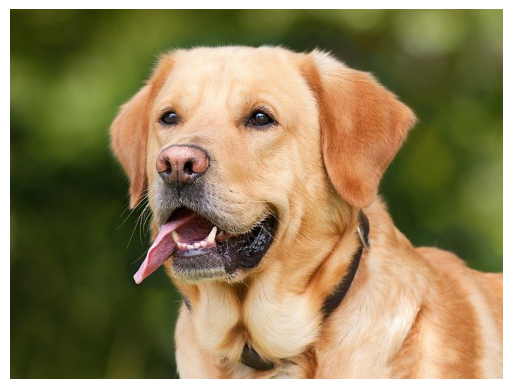

Prediction 0: Labrador retriever, 61.20%
Prediction 1: golden retriever, 31.79%
Prediction 2: tennis ball, 0.94%
Prediction 3: Rhodesian ridgeback, 0.86%
Prediction 4: soccer ball, 0.51%


In [ ]:

# load the class labels
with open('imagenet_classes.txt') as f:
    whip = {en:line.strip() for en,line in enumerate(f.readlines())}

for _, image_path in enumerate(image_paths):

    # Read image using opencv.
    img = Image.open(image_path)

    # get evaluation transformations
    weights = ResNet50_Weights.IMAGENET1K_V1
    preprocess = weights.transforms()

    # Preprocess the batched image
    img_transformed = preprocess(img)

    # Add batch dimension at the beginning.
    image_batch = torch.unsqueeze(img_transformed, axis=0)

    # Forward pass through the model.
    predictions = model(image_batch)

    #apply softmax layer
    predictions=torch.softmax(predictions,-1)

    # Get top 5 predictions
    sorted_predictions = np.argsort(predictions.detach().numpy())[0,-5:][::-1]

    # Display the image and print the top 5 predictions for each.
    plt_image = plt.imread(image_path)
    plt.imshow(plt_image)
    plt.axis('off')
    plt.show()
    for num, pred in enumerate(sorted_predictions):
        print(f"Prediction {num}: {whip[pred].split(',')[0]}, {predictions[0][pred]*100:.2f}%")

For every image, we are printing the top-5 predictions based on the probability scores from the network. For the image of the dog, although the top prediction is `Labrador_retriever`, the second prediction, which is, `golden_retriever` is indistinguishable by most people. The ImageNet dataset has a lot of granularity and therefore contains distinct classes for many object types that are very similar. For example, there are 15 different types of snakes in the dataset.

## 5 Conclusion

In this notebook, we learned how to perform image classification using a pre-trained ResNet50 model. In subsequent notebooks, you will learn more about the pre-trained models that `torchvision` provides and how to create a simple pipeline where you can perform inference using any of those pre-trained models.

As a simple exercise, try using some of your own images or download images from the internet and modify the initial portion of this notebook to classify them. You will be amazed by the model's performance!